In [1]:
# Config
seed = 42 
training_split_ratio = 0.9 
num_epochs = 5

compute_histograms = False
train_whole_images = False
train_patches = True

In [2]:
import copy
import enum
import random; random.seed(seed)
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
torch.manual_seed(seed)

import torchio as tio
from torchio import AFFINE, DATA

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm import tqdm

import os

print('TorchIO version:', tio.__version__)

TorchIO version: 0.20.0


Define some visualization functions:

In [3]:
#@title (Helper functions, double-click here to expand)
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.io.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as f:
        subject[image_name].save(f.name)
        temp_filename = f.name
    try:
        show_nifti(temp_filename)
    finally:
        os.remove(temp_filename)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

## Transform data

In [4]:
# original_path = Path('Dataset/BHSD_original')
# transformed_path = Path('Dataset/BHSD_transformed')
# images_dir = original_path / 'images'
# labels_dir = original_path / 'ground_truths'
# transformed_images_dir = transformed_path / 'images'
# transformed_labels_dir = transformed_path / 'ground_truths'

# ###
# preprocessing_transforms = tio.Compose([tio.ToCanonical(), tio.Resample('ct')])

# image_paths = sorted(images_dir.glob('*.nii.gz'))
# label_paths = sorted(labels_dir.glob('*.nii.gz'))

# for image_path, label_path in zip(image_paths, label_paths):
#     subject = tio.Subject(
#         ct=tio.ScalarImage(image_path),
#         brain=tio.LabelMap(label_path),
#     )
#     transformed_subject = preprocessing_transforms(subject)
    
#     transformed_subject.ct.save(transformed_images_dir / image_path.name)
#     transformed_subject.brain.save(transformed_labels_dir / label_path.name)

# print('Transformation and saving completed.')

## Data

In [5]:
# Dataset
dataset_path = Path('Dataset\BHSD_transformed')
histogram_landmarks_path = 'landmarks.npy'

In [6]:
images_dir = dataset_path / 'images'
labels_dir = dataset_path / 'ground_truths'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths) # image and label share the same IDs

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        ct=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 192 subjects


Subject(Keys: ('ct', 'brain'); images: 2)
ScalarImage(shape: (1, 512, 512, 28); spacing: (0.49, 0.49, 5.29); orientation: RAS+; dtype: torch.FloatTensor; memory: 28.0 MiB)


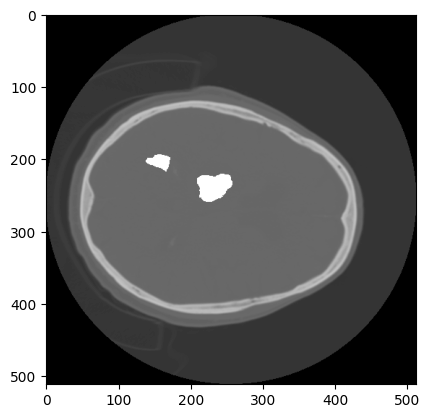

In [7]:
one_subject = dataset[0]
print(one_subject)
print(one_subject.ct)
show_subject(tio.ToCanonical()(one_subject), 'ct', label_name='brain')

## Normalization

In [8]:
paths = image_paths

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        color = 'red'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004)
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    # graph = display.Image('Assets/pre-norm-hist.png')
    pass
# graph

##### Normalization

In [9]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

  0%|          | 0/192 [00:00<?, ?it/s]


Trained landmarks: [  0.      0.196   0.342  16.256  18.624  19.924  21.289  26.722  49.683
  55.728  57.111  59.194 100.   ]


In [10]:
landmarks_dict = {'ct': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.ct.data
        path = str(sample.ct.path)
        color = 'red'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    # graph = display.Image('Assets/post-norm-hist.png')
    pass
# graph

##### Z-normalization

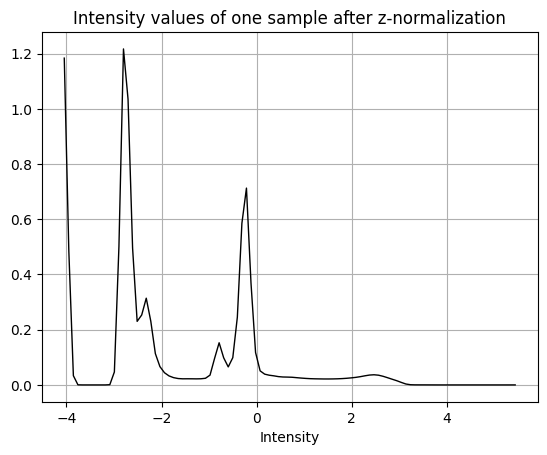

In [11]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.ct.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

## Training a network



In [12]:
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

training_transform = Compose([
    ToCanonical(),
    Resample(4),
    CropOrPad((48, 60, 48), padding_mode='reflect'),
    RandomMotion(),
    HistogramStandardization({'ct': landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    RandomNoise(),
    RandomFlip(axes=(0,)),
    OneOf({
        RandomAffine(): 0.8,
        RandomElasticDeformation(): 0.2,
    }),
])

validation_transform = Compose([
    ToCanonical(),
    Resample(4),
    CropOrPad((48, 60, 48), padding_mode='reflect'),
    HistogramStandardization({'ct': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 172 subjects
Validation set: 20 subjects


### Deep learning stuff

In [13]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['ct'][DATA].to(device)
    foreground = batch['brain'][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        torch.save(model.state_dict(), f'Assets\model\{weights_stem}_epoch_{epoch_idx}.pth')

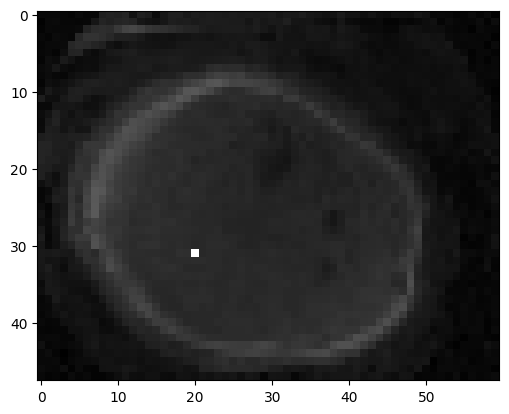

In [14]:
training_instance = training_set[42]  # transform is applied in SubjectsDataset
show_subject(training_instance, 'ct', label_name='brain')

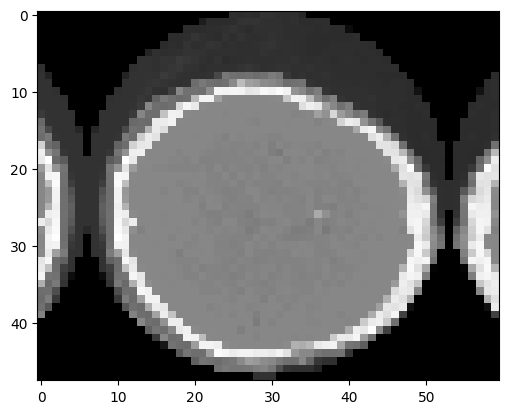

In [15]:
validation_instance = validation_set[6]
show_subject(validation_instance, 'ct', label_name='brain')

### Whole images

In [16]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

Visualize axial slices of one batch

In [17]:
one_batch = next(iter(training_loader))

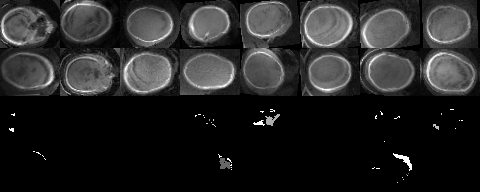

In [18]:
k = 24
batch_ct = one_batch['ct'][DATA][..., k]
batch_label = one_batch['brain'][DATA][..., k]
slices = torch.cat((batch_ct, batch_label))
image_path = 'batch_whole_images.png'
save_image(slices, image_path, nrow=training_batch_size//2, normalize=True, scale_each=True, padding=0)
display.Image(image_path)

Train

In [19]:
model, optimizer = get_model_and_optimizer(device)

if train_whole_images:
    weights_stem = 'whole_images'
    train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
else:
    weights_path = 'Assets\model\whole_images_epoch_5.pth'
    model.load_state_dict(torch.load(weights_path))

Inference

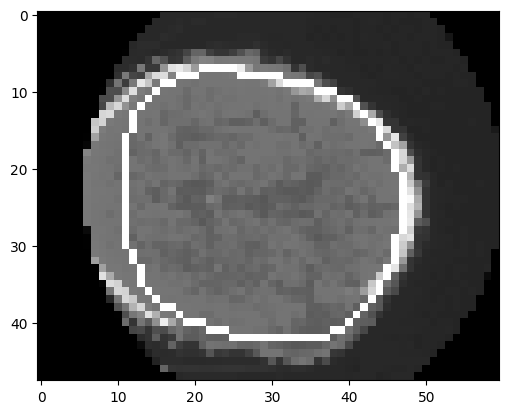

In [20]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
foreground = labels[0].cpu().numpy().astype(np.uint8)
affine = batch['ct'][AFFINE][0].numpy()
label_image = tio.io.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.io.sitk_to_nib(border)
image_array = inputs[0, 0].cpu().numpy()
image_array[border_array[0] > 0.5] = image_array.max()
nii = nib.Nifti1Image(image_array, affine)
show_nifti(nii)

### Patch-based

In [21]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = 24
samples_per_volume = 5
max_queue_length = 300

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Visualize axial slices of one batch

In [23]:
one_batch = next(iter(training_loader))

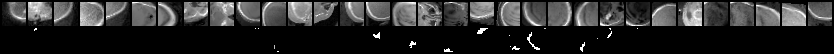

In [26]:
# one_batch = next(iter(training_loader))
k = int(patch_size // 4)
batch_ct = one_batch['ct'][DATA][..., k]
batch_label = one_batch['brain'][DATA][..., k]
slices = torch.cat((batch_ct, batch_label))
image_path = 'Assets/batch_patches.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True)
display.Image(image_path)

Train

In [27]:
model, optimizer = get_model_and_optimizer(device)

if train_patches:
    weights_stem = 'patches'
    train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
else:
    weights_path = 'Assets\model\patches_epoch_5.pth'
    model.load_state_dict(torch.load(weights_path))

  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\data\dataset.py", line 99, in __getitem__
    subject = self._transform(subject)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\transforms\transform.py", line 168, in __call__
    transformed = self.apply_transform(subject)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\transforms\augmentation\composition.py", line 51, in apply_transform
    subject = transform(subject)  # type: ignore[assignment]
              ^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\transforms\transform.py", line 168, in __call__
    transformed = self.apply_transform(subject)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\transforms\preprocessing\spatial\resample.py", line 192, in apply_transform
    floating_sitk = image.as_sitk(force_3d=True)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\data\image.py", line 643, in as_sitk
    return nib_to_sitk(self.data, self.affine, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchio\data\io.py", line 315, in nib_to_sitk
    image = sitk.GetImageFromArray(array, isVector=is_multichannel)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\SimpleITK\extra.py", line 324, in GetImageFromArray
    img = Image(shape, id, number_of_components)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sung2_8l7o06c\AppData\Local\Programs\Python\Python311\Lib\site-packages\SimpleITK\SimpleITK.py", line 3128, in __init__
    _SimpleITK.Image_swiginit(self, _SimpleITK.new_Image(*args))
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Exception thrown in SimpleITK new_Image: D:\a\1\sitk-build\ITK-prefix\include\ITK-5.3\itkImportImageContainer.hxx:191:
Failed to allocate memory for image.


# Inference

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torchio/data/inference/aggregator.py:116: UserWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message)


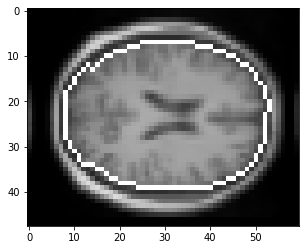

In [ ]:
sample = random.choice(validation_set)
input_tensor = sample.ct.data[0]
patch_size = 48, 48, 48  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['ct'][DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

foreground = aggregator.get_output_tensor()
affine = sample.ct.affine
label_image = tio.io.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.io.sitk_to_nib(border)
input_tensor[border_array > 0.5] = input_tensor.max()
nii = nib.Nifti1Image(input_tensor.numpy(), affine)
show_nifti(nii)